<a href="https://colab.research.google.com/github/levyjonathan31/GoogleCollabCNN/blob/main/Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

In [ ]:
# Load mnist data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [ ]:
# Set random seed
np.random.seed(7)

# The layer classes for our network

In [ ]:
from abc import ABC, abstractmethod  # this is important for some of the OOP we're doing
from typing import List              # this is also important for some type suggestion stuff

## Abstract base layer

In [ ]:
class Layer(ABC):
    '''
        Abstract class for other layer classes to inherit from.
    '''
    @abstractmethod
    def forward_propagate(self, input_data):
        pass

    @abstractmethod
    def back_propagate(self, gradient, lr):
        pass

## Conv Layer

In [ ]:
class ConvLayer(Layer):
    def __init__(self, num_filters, conv_size=(3, 3), activation='relu'):
        self.num_filters = num_filters
        self.conv_width, self.conv_height = conv_size

        # Determine activation function
        if activation == 'sigmoid': activation_function = lambda x: 1 / (1 + np.exp(-x))
        elif activation == 'tanh': activation_function = lambda x: np.tanh(x)
        else: activation_function = lambda x: np.maximum(0, x)  # relu by default, just in case

        # Vectorize it for ease of use with numpy
        self.activation = np.vectorize(activation_function)

        # Using Xavier initialization
        # xavier_scaling = np.sqrt(6.0 / (conv_width * conv_height * input_channels))
        # self.W = xavier_scaling * np.random.randn(num_filters, conv_width, conv_height, input_channels)
        self.W = np.random.uniform(low=-0.3, high=0.3, size=(self.num_filters, self.conv_width, self.conv_height))
        self.b = np.zeros((num_filters, 1))

    def forward_propagate(self, input):
        input_height, input_width = input.shape

        # initialize output array (note: this is typically num_filters x 30 x 30, or whatever your input shape is)
        output = np.zeros((self.num_filters, input_height - self.conv_height + 1, input_width - self.conv_width + 1))

        # apply convolution
        for f in range(self.num_filters):
            output[f] += convolve2d(input, self.W[f], mode='valid', boundary='fill') + self.b[f]

        # clip values and apply activation function
        output = self.activation(output)
        output = np.clip(output, 0, 255)

        # black padding to the output
        return np.pad(output, ((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0)

    def back_propagate(self, gradient, lr):
        raise Exception("Not yet implemented")

## Pooling Layer

In [ ]:
class MaxPoolingLayer(Layer):
    def __init__(self, pool_size=(2, 2)):
        self.pool_size = pool_size

    def forward_propagate(self, input):
        batch_size, input_height, input_width = input.shape
        pool_height, pool_width = self.pool_size

        # Calculate dimensions of the pooled output
        output_height = input_height // pool_height
        output_width = input_width // pool_width

        # reshape the input to make pooling more efficient
        reshaped_input = input.reshape(batch_size, output_height, pool_height, output_width, pool_width)

        # effectively performs max pooling over the specified pool_height and pool_width
        output = reshaped_input.max(axis=(2, 4))

        return output

    def back_propagate(self, gradient, lr):
        raise Exception("Not yet implemented")

# Flatten Layer

In [ ]:
class FlattenLayer(Layer):
    def __init__(self):
        pass  # i don't think we need anything?

    def forward_propagate(self, input):
        batch_size = input.shape[0]

        # Calculate the flattened size
        flattened_size = np.prod(input.shape[1:])  # ignores the first dimension (batch size or num filters ??)

        # Reshape the input to a flat vector
        flattened_output = input.reshape(batch_size, flattened_size)

        return flattened_output

    def back_propagate(self, gradient, lr):
        raise Exception("Not yet implemented")

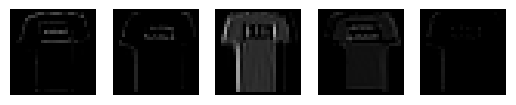

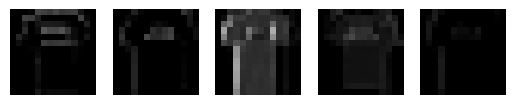

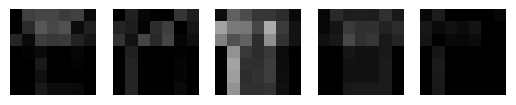

[2.86793707e-01 6.41119533e+01 7.06599561e+01 7.05263015e+01
 5.93963832e+01 6.59311941e+01 9.47916832e+00 0.00000000e+00
 4.35560861e+01 8.56752831e+01 7.08368821e+01 8.26669136e+01
 1.14941668e+01 3.29815934e+01 3.74046988e+01 1.02782322e+01
 5.98548848e+01 5.57658850e+01 5.82414878e+01 3.39392450e+01
 2.15181913e+01 1.34079107e-01 3.50450137e+00 1.08878604e+01
 0.00000000e+00 0.00000000e+00 6.60335224e+00 1.71313968e-01
 0.00000000e+00 2.28000050e-01 2.53392120e+01 0.00000000e+00
 0.00000000e+00 3.35006269e+00 0.00000000e+00 0.00000000e+00
 4.54744983e-01 1.57653290e+01 0.00000000e+00 0.00000000e+00
 3.95951325e-01 0.00000000e+00 0.00000000e+00 1.67951275e-01
 2.57553883e+01 1.27766483e+01 1.27161648e+01 9.02637754e+00
 4.61950445e-02]


In [ ]:
input_image = x_train[1]
conv_layer = ConvLayer(num_filters=5, conv_size=(3, 3))
max_pooling_layer = MaxPoolingLayer(pool_size=(2, 2))
flatten_layer = FlattenLayer()

feature_map = conv_layer.forward_propagate(input_image)
plot_images_in_a_line(feature_map)

output_images = max_pooling_layer.forward_propagate(feature_map)
plot_images_in_a_line(output_images)

output_images = max_pooling_layer.forward_propagate(output_images)
plot_images_in_a_line(output_images)

feature_vectors = flatten_layer.forward_propagate(output_images)

print(feature_vectors[0])

# Fully Connected Layer

In [ ]:
class FCLayer(Layer):
    def __init__(self, input_dim, output_dim, activation = "relu"):
        # using He initialization
        he = np.sqrt(2/(input_dim + output_dim))
        self.W = np.random.uniform(low=-he, high=he, size=(output_dim, input_dim))
        self.activation = activation
        self.input_vector = None

    def activate(self, Z):
        return np.maximum(0.0, Z)  # ReLU

    def gradient(self, dA, Z):
        return dA * (Z > 0.0)  # ReLU derivative

    def soft_max(self, Z):
        # Essentially factoring out e^Z/e^Z
        shifted_Z = Z - np.max(Z, axis=1, keepdims=True)
        exp_Z = np.exp(shifted_Z)
        softmax_result = exp_Z / np.sum(exp_Z, axis=1, keepdims=True)
        return softmax_result

    def forward_propagate(self, input):
        # y = Wx + b
        self.input_vector = input
        linear_transform = input @ self.W.T
        nonlinear_transform = self.activate(linear_transform)
        if self.activation == "softmax":
            nonlinear_transform = self.soft_max(linear_transform)
        return nonlinear_transform

    def back_propagate(self, grad_y, lr):
        # Apply the derivative of the activation function
        # Compute the gradients of the loss with respect to the weights and biases
        grad_w = grad_y.T @ self.input_vector
        np.clip(grad_w, -0.5, 0.5, out=grad_w)
        self.W -= lr * grad_w
        # compute next grad_y
        grad_y = grad_y @ self.W
        relu_derivative = (self.input_vector > 0).astype(float)
        grad_y = np.multiply(grad_y, relu_derivative)
        return grad_y

In [ ]:
 # class ActivationLayer(FCLayer):
#     def activate(Z):
#         return np.maximum(0.0, Z)  # ReLU

#     def gradient(dA, Z):
#         return dA * (Z > 0.0)  # ReLU derivative

In [ ]:
# class FCLayerSoftMax(Layer):
#     def activate(Z):
#         return np.exp(Z)/np.sum(np.exp(Z), axis=1, keepdims = True)

# Other (helper) functions

In [ ]:
def convert_to_onehot(y_train):
    num_classes = len(np.unique(y_train))
    y_cat = np.eye(num_classes)[y_train]
    return y_cat

def plot_images_in_a_line(images, cmap='gray'):
    num_images = len(images)
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap=cmap, vmin=0, vmax=255)
        plt.axis('off')  # Turn off axis ticks and labels

    plt.show()

# Our Network

In [ ]:
class Network:
    def __init__(self, layers: List[Layer] = None):
        if layers is None:
            layers = []
        self.layers = layers  # The layers for our CNN

    def summary(self):
        ''' Prints a summary of the network architecture '''
        raise Exception("Not yet implemented")

    def complete_forward_propagation(self, X):
        ''' Forward propagation through all layers '''
        b = X
        for layer in self.layers:
            b = layer.forward_propagate(b)
        return b

    def complete_backward_propagation(self, lr, grad, inputs):
        ''' Backward propagation through all layers '''
        # technically this is dL/dy
        dy = grad
        for layer in reversed(self.layers):
            dy = layer.back_propagate(dy, lr)

    def predict(self, X):
        ''' Forward propagation to obtain predictions '''
        # reshaped it so it can be treated as a 2d array
        X = X.reshape(1,-1)
        return self.complete_forward_propagation(X)

    def categorical_cross_entropy(self, pred, y_cat):
        ''' Compare truth values to predicted using cce'''
        cce = -np.sum(y_cat * np.log(pred), axis=1, keepdims=True) # Ensure y_cat is one hot encoded
        return cce

    def fit(self, x_train_norm, y_cat, x_test_norm, y_test_cat, epochs, batch_size, lr):
        ''' Propagates forward, performs cce, backpropagates '''
        for epoch in range(epochs):
            # Shuffles training data and splits into batches
            randomized_indices = np.random.permutation(len(x_train_norm))
            randomized_data = x_train_norm[randomized_indices]
            randomized_labels = y_cat[randomized_indices]
            avg_loss = 0
            print("EPOCH: ", epoch + 1)
            # Trains on each batch
            for i in range(0, len(x_train_norm), batch_size):
              batch_data = randomized_data[i:i + batch_size]
              batch_cat = randomized_labels[i:i + batch_size]
              forward_prop = self.complete_forward_propagation(batch_data)
              pred = forward_prop
              pred = np.clip(pred, 1e-8, None)
              self.complete_backward_propagation(lr, pred - batch_cat, forward_prop)
              cce = np.sum(self.categorical_cross_entropy(pred, batch_cat), axis=1)
              avg_loss += np.mean(cce)
            # Calculate avg loss
            avg_loss /= np.ceil(len(x_train_norm) / batch_size)
            print("Categorical Cross Entropy: ", avg_loss)

            # Run through test set calculate accuracy
            test_preds = self.complete_forward_propagation(x_test_norm)

            pred_cats = np.argmax(test_preds, axis=1)
            true_cats = np.argmax(y_test_cat, axis=1)
            accuracy = np.mean(np.equal(pred_cats, true_cats))
            print("Test Set Accuracy: ", accuracy)
            print("----------------------------------------------")

    def add_layer(self, layer: Layer):
        ''' Add a layer to the network dynamically '''
        self.layers.append(layer)

Helper (MNIST Fashion Specific)

In [ ]:
def label_to_fashion(label):
    labels = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankleboot"]
    return labels[label]

In [ ]:
y_categorical = convert_to_onehot(y_train)
y_test_categorical = convert_to_onehot(y_test)
my_nn = Network()
fc_layer_1 = FCLayer(784, 392)
fc_layer_2 = FCLayer(392, 196)
fc_layer_3 = FCLayer(196, 98)
fc_layer_4 = FCLayer(98, 49)
fc_layer_5 = FCLayer(49, 10, "softmax")
my_nn.add_layer(fc_layer_1)
my_nn.add_layer(fc_layer_2)
my_nn.add_layer(fc_layer_3)
my_nn.add_layer(fc_layer_4)
my_nn.add_layer(fc_layer_5)

In [ ]:
x_train_normalized = x_train.reshape(60000,28*28)/255
x_test_normalized = x_test.reshape(10000, 28*28)/255
my_nn.fit(x_train_normalized, y_categorical, x_test_normalized, y_test_categorical, 20, 1000, 0.0005)

EPOCH:  1
Categorical Cross Entropy:  1.9250800808081052
Test Set Accuracy:  0.5541
----------------------------------------------
EPOCH:  2
Categorical Cross Entropy:  1.053332906096983
Test Set Accuracy:  0.6246
----------------------------------------------
EPOCH:  3
Categorical Cross Entropy:  0.8381914849094948
Test Set Accuracy:  0.6872
----------------------------------------------
EPOCH:  4
Categorical Cross Entropy:  0.7492646050490201
Test Set Accuracy:  0.7157
----------------------------------------------
EPOCH:  5
Categorical Cross Entropy:  0.692553851764614
Test Set Accuracy:  0.7314
----------------------------------------------
EPOCH:  6
Categorical Cross Entropy:  0.6579545824500124
Test Set Accuracy:  0.7598
----------------------------------------------
EPOCH:  7
Categorical Cross Entropy:  0.6314306270018287
Test Set Accuracy:  0.7629
----------------------------------------------
EPOCH:  8
Categorical Cross Entropy:  0.6163182405026061
Test Set Accuracy:  0.7642
-

# Other Considerations...
Dropout weights

[[0.00000000e+000 0.00000000e+000 1.20540841e-083 0.00000000e+000
  1.00000000e+000 0.00000000e+000 8.38856682e-205 0.00000000e+000
  0.00000000e+000 0.00000000e+000]]
Predicted Label:  Coat
Actual Label:  Coat


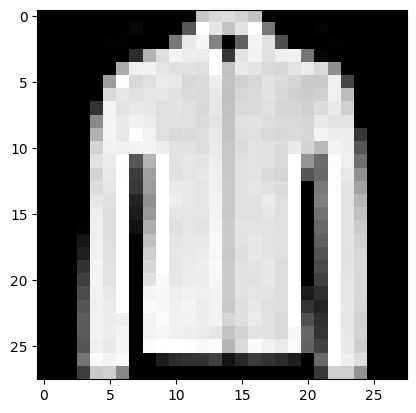

In [ ]:
ind = np.random.randint(0, 9000)
x_test_v = x_test[ind].reshape(28*28)
fwd_prop = my_nn.predict(x_test_v)
print(fwd_prop)
pred_label = np.argmax(fwd_prop)
print("Predicted Label: ",label_to_fashion(pred_label))
print("Actual Label: ",label_to_fashion(y_test[ind]))
plt.imshow(x_test[ind], cmap='gray')

Interesting test

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Predicted Label:  Bag


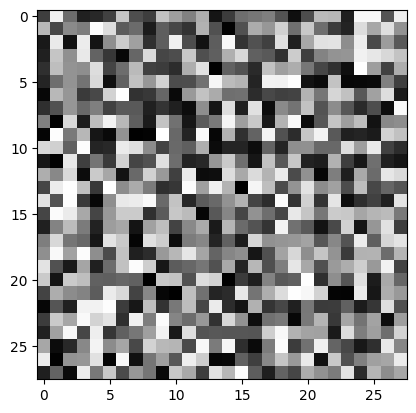

In [ ]:
random_image = np.random.randint(0, 256, size=(28, 28), dtype=np.uint8)
random_image.reshape(28*28)
fwd_prop = my_nn.predict(random_image)
print(fwd_prop)
pred_label = np.argmax(fwd_prop)
print("Predicted Label: ",label_to_fashion(pred_label))
plt.imshow(random_image, cmap='gray')

#Sources?
https://paperswithcode.com/method/xavier-initialization#:~:text=Xavier%20Initialization%2C%20or%20Glorot%20Initialization,a%20n%20o%20u%20t%20%5D

https://www.v7labs.com/blog/cross-entropy-loss-guide#:~:text=Categorical%20Cross%20Entropy%20is%20also,N%20classes%20for%20each%20image.

https://www.mldawn.com/back-propagation-with-cross-entropy-and-softmax/